In [1]:
run draw_confetti.py tempconfetti 3 4 8

svg2png tempconfetti/0000_035_003.png
svg2png tempconfetti/0001_028_003.png
svg2png tempconfetti/0002_030_004.png
svg2png tempconfetti/0003_006_004.png
svg2png tempconfetti/0004_043_004.png
svg2png tempconfetti/0005_008_004.png
svg2png tempconfetti/0006_037_003.png
svg2png tempconfetti/0007_045_004.png


In [3]:
# Adapted from Adrian Rosebrock https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# build the network

def create_cnn(width, height, depth, nfilters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, nf) in enumerate(nfilters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(nf, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer: JR not sure what the role of this is
    x = Dense(4)(x)
    x = Activation("relu")(x)

    x = Dense(2, activation="linear")(x)    ################  2D output

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

import glob
import cv2

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from os.path import join
from glob import glob
import pandas
from PIL import Image

def setup(datafolder, columns_to_use ):

    datafile   = join( datafolder , datafolder+'.txt' )
    # construct the path to the input .txt file that contains information
    # on each image in the dataset and then load the dataset
    print("Loading attributes...")
    
    #df = load_attributes(inputPath)  # replace with direct code to load attributes
    # df should be a numpy array with only the desired columns
    df = pandas.read_csv(datafile, sep=' ')[ columns_to_use ].copy()

    # load the images and then scale the pixel intensities to the
    # range [0, 1]
    print("Loading images...")
    #images = load_images(df, datafolder)#
    imagefiles = sorted( glob( join(datafolder,'*.png')   ))
    
    #images = np.array([cv2.imread(imagefile)[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    # Instead use PIL.Image to avoid problems some are having with installing opencv (cv2)
    images = np.array([np.array(Image.open(imagefile))[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    print(images.shape)
    images = images / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    #split = train_test_split(df, images, test_size=0.25, random_state=42)   # can alternatively make your own function to do this
    #(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
    
    # Trying to get rid of dependencies: I coded train/test split from scratch instead of using sklearn
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    nimages = len(images)
    ntest = int( nimages * 0.25 )
    intest = np.zeros(nimages,dtype=bool)
    intest[ np.random.choice( np.arange(nimages), ntest, replace=False ) ] = True
    intrain = ~intest
    testImagesX  = images[intest ,:,:,:].copy()
    trainImagesX = images[intrain,:,:,:].copy()
    testAttrX  = df.values[intest ,:]
    trainAttrX = df.values[intrain,:]
    
    # to rescale trainY and testY
    minAttr = trainAttrX.min(axis=0)
    maxAttr = trainAttrX.max(axis=0)
    rangeAttr = maxAttr - minAttr
    
    trainAttrX -= minAttr
    trainAttrX = (trainAttrX/rangeAttr)
    
    testAttrX -= minAttr
    testAttrX = (testAttrX/rangeAttr)
    
    # let's return minAttr and rangeAttr for use in interpretation of predictions
    return trainAttrX,testAttrX, trainImagesX, testImagesX, minAttr, rangeAttr
    

tra,testa,tri,testi, mina,rangea = setup('triangles_squares_pentagons',['npolygons', 'nv'])
print(mina,rangea)

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(75,50, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(tri,tra, validation_data=(testi, testa),
        epochs=20, batch_size=8)

#model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting")
preds = model.predict(testi)
# undo rescaling and shifting of data
preds = preds*rangea + mina  # predictions of network
testa = testa*rangea + mina  # actual values
# next: compare (graphically) predictions with actual values

Loading attributes...
Loading images...
(2000, 50, 75, 3)
[0 3] [50  2]
Training model...
Train on 1500 samples, validate on 500 samples
Epoch 1/20
1500/1500 [==============================] - 36s 24ms/sample - loss: 1.6367 - val_loss: 0.9323
Epoch 2/20
1500/1500 [==============================] - 27s 18ms/sample - loss: 0.4999 - val_loss: 0.2229
Epoch 3/20
1500/1500 [==============================] - 26s 17ms/sample - loss: 0.2824 - val_loss: 0.1580
Epoch 4/20
1500/1500 [==============================] - 30s 20ms/sample - loss: 0.2168 - val_loss: 0.1898
Epoch 5/20
1500/1500 [==============================] - 29s 19ms/sample - loss: 0.1741 - val_loss: 0.1221
Epoch 6/20
1500/1500 [==============================] - 25s 17ms/sample - loss: 0.1546 - val_loss: 0.1548
Epoch 7/20
1500/1500 [==============================] - 26s 17ms/sample - loss: 0.1385 - val_loss: 0.1411
Epoch 8/20
1500/1500 [==============================] - 31s 20ms/sample - loss: 0.1256 - val_loss: 0.6855
Epoch 9/20
1500

In [4]:
import matplotlib.pyplot as plt

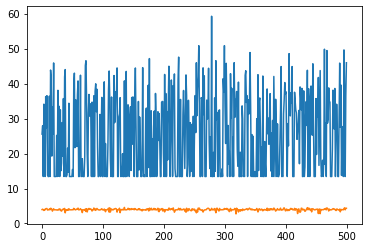

In [7]:
plt.plot(preds)

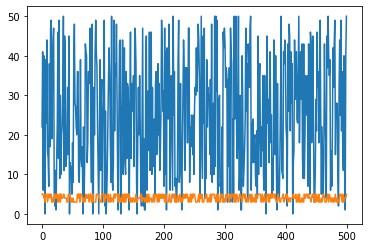

In [8]:
plt.plot(testa)

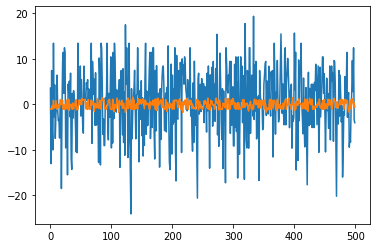

In [12]:
plt.plot(preds-testa)